# 프로젝트 고양이 수염 스티커 만들기

## step 1. 고양이 수염 이미지 및 얼굴 이미지 준비

### 고양이 수염은 일단 제시 해준 파일을 다운 받고 나의 얼굴 이미지로 해보겠다

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


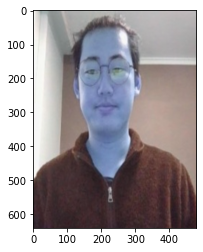

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

### 사진 비율을 640,360 에서 640,480 으로 변경을 하였다.

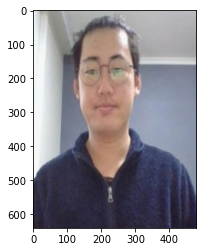

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### opencv 는 BGR(파랑,녹색,빨강)으로 사용 하는걸 알게되었고 
### RGB(빨강,녹색,파랑) 변경하는 작업처리를 하였다.

## step 2. 얼굴 검출 & 랜드마크 검출 하기

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()  

### hog detector 선언

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) 


### bounding box 추출

rectangles[[(118, 139) (304, 325)]]


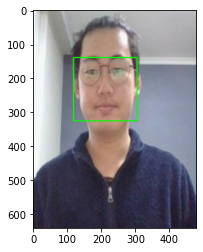

In [6]:
print(dlib_rects) 

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 랜드마크 모델 불러오기

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

### 객체 변환 랜드마크 얼굴 개수 저장

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 랜드마크 영상 출력하기

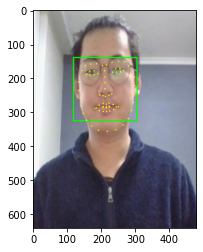

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## step 3. 스티커 적용 위치 확인하기

In [10]:
x1 = (landmark[2][0] + landmark[30][0])/2
y1 = (landmark[2][1] + landmark[36][1])/2
print("({0},{1})".format(x1, y1))

(173.5,222.5)


In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] 
    w = int((landmark[30][0] - x1) * 2)
    h = int(dlib_rect.width()/2)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(210, 231)
(x,y) : (210,231)
(w,h) : (73,93)


### 처음에 위치가 왕관 위치에서 맴돌아서 뇌정지가 순간적으로 왔었다. 
### 68개의 위치를 임의로 무조건 넣어보았었는데 코근처까지는 왔지만 딱 자리를 잡지 않았었다. 그래서 슬랙/구글 에서 미친듯이 검색하고 찾아보았지만 완벽히 이해가 되지않았었다. 최후의 방법인 조원/퍼실 님에게 질문들을 난발하였고 차근차근 Lanmark 위치 부터 좌표에 대해 설명을 듣고 이해를 하고 나서야 코드에서 변경해야 될 부분을 알게 되었다. 

In [12]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(93, 73, 3)


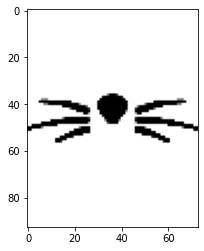

In [13]:
plt.imshow(img_sticker)
plt.show()

### 고양이 수염 스티커 이미지 확인

In [14]:
refined_x = x - w //2   # left
refined_y = y - h //2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (174,185)


In [15]:
#img_sticker = img_sticker[-refined_y:]
#print (img_sticker.shape)

In [16]:
#refined_y = 0 
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

### 위 두개의 주석들은 사진에서 돌출되는 부분을 잘라주는 코드

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

### 작은만한 함정이 숨어있었지만 힌트를 통해 쉽게 해결할수있었다. img_sticker==0 의 함정만 있을줄알았는데 could not be broadcast 할수 없다는 output 나와서 당황했지만 구글링을 통해서 refined 문제를 알수있었고 refined + 해주면서 해결하였다.

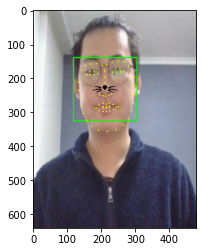

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## Step 4. 스티커 적용하기

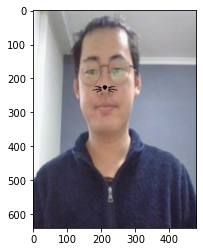

In [19]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 수염을 너무 작게했나...? 

## Step 5. 문제점 찾아보기

### 제시 해준 여러가지 문제점에 대해 생각을 해보았다. 일단 얼굴 각도에 따라 스티커를 위치조정을 좌표를 생각해서 다시 일일 작업을 해야한다. 각도가 변하면 좌표들이 변경되기때문이다. 멀리서 촬영하거나 옆으로 누워서 촬영하게 되면 얼굴이 작아지거나 멀어지기 때문에 인식 하기 힘들다.

# 이번 프로젝트를 마치며...

### landmark 까지는 LMS를 통해 공부하고 나서 순조롭게 진행 되어 이번 프로젝트는 할만하네?! 라고 생각을 한순간 스티커 위치 조정 하는 부분에서 생각지도 못한 어려움이 찾아왔다. 68개의 landmark 위치를 변경해가며 아무 넣어봐도 이마와눈에서 맴돌던 고양이수염.... 그리고 Sticker_area 두가지 어려움이있었지만 이번 프로젝트를 통해서 코드를 좀 더 이해하게 되었고 error 가 발생하여도 읽어보면 거기에 힌트가 있고 수정 하여 해결해나가면서 조금 더 방향성을 알게 해준 프로젝트였다. 
